In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from scipy.stats import entropy

In [2]:
data = pd.read_csv('modified_data7.csv', encoding='cp1252')

# 필요없는 피처 날리기
data = data.drop("subbedOutTime", axis=1)
data = data.drop("position", axis=1)
data = data.drop("fantasyScore", axis=1)

# 포지션만 있고 세부 포지션 널값처리
# 'positionStringShort'의 널값이 있는 행 찾기
null_positions = data[data['positionStringShort'].isna()]

# 각 널값에 대해 처리
for index, row in null_positions.iterrows():
    # 현재 널값이 있는 행의 'name' 가져오기
    name = row['name']
    # 해당 'name'을 가진 모든 행에서 'positionStringShort'의 최빈값 찾기
    most_frequent_position = data[data['name'] == name]['positionStringShort'].mode()[0]
    # 널값 채우기
    data.at[index, 'positionStringShort'] = most_frequent_position

data = data.drop("name", axis=1)
# rating 널값 제거, 개수가 매우적어 없는거만 제거
data = data.dropna(subset=["rating"])

# x , y 나누기
data_x = data.drop("rating", axis=1)
data_y = data["rating"]

# 학습, 테스트 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)

# 'positionStringShort'와 'positionRow' 열 선택
x_train_cat = x_train[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder = OneHotEncoder()
# 원-핫 인코딩 적용
x_train_cat_1hot = cat_encoder.fit_transform(x_train_cat)
# positionStringShort, positionRow은 카테고리컬
x_train_num = x_train.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features = x_train_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled = scaler.fit_transform(numeric_features)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns,
                                          index=x_train_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df = numeric_features_scaled_df.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled = x_train_num.copy()
data_num_scaled[numeric_features.columns] = numeric_features_scaled_df

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_train_cat_1hot_df = pd.DataFrame(x_train_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(),
                                   index=x_train.index)

# 불리언 타입의 데이터만 선택
bool_features = x_train_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_train_prepared = pd.concat([data_num_scaled, bool_features, x_train_cat_1hot_df], axis=1)


In [3]:
# x_test, y_test


# 'positionStringShort'와 'positionRow' 열 선택
x_test_cat = x_test[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder2 = OneHotEncoder()
# 원-핫 인코딩 적용
x_test_cat_1hot = cat_encoder2.fit_transform(x_test_cat)

# positionStringShort, positionRow은 카테고리컬
x_test_num = x_test.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features2 = x_test_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler2 = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled2 = scaler.transform(numeric_features2)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df2 = pd.DataFrame(numeric_features_scaled2, columns=numeric_features2.columns,
                                          index=x_test_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df2 = numeric_features_scaled_df2.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled2 = x_test_num.copy()
data_num_scaled2[numeric_features2.columns] = numeric_features_scaled_df2

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_test_cat_1hot_df = pd.DataFrame(x_test_cat_1hot.toarray(), columns=cat_encoder2.get_feature_names_out(),
                                   index=x_test.index)

# 불리언 타입의 데이터만 선택
bool_features2 = x_test_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_test_prepared = pd.concat([data_num_scaled2, bool_features2, x_test_cat_1hot_df], axis=1)

In [4]:
svm_reg = LinearSVR(epsilon = 0.1,C=50, max_iter=7000)
rnd_for = RandomForestRegressor(n_estimators=300,max_depth=47,bootstrap=True, max_features='auto', min_samples_split=14,min_samples_leaf=4, n_jobs=-1)
sgd_reg_l2 = SGDRegressor(max_iter=1000, tol=1e-3, penalty='l2', eta0=0.01)
gbrt = GradientBoostingRegressor(max_depth=4, n_estimators=96, learning_rate=0.1644)
tree_reg = DecisionTreeRegressor(max_depth=3)

In [5]:
voting_regressor = VotingRegressor(estimators=[('svm', svm_reg), ('rf', rnd_for), 
                                               ('sgd', sgd_reg_l2), ('gbrt', gbrt), 
                                               ('tree', tree_reg)])


In [6]:
voting_regressor.fit(x_train_prepared, y_train)

C:\Users\junhe\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingRegressor(estimators=[('svm',
                             LinearSVR(C=50, epsilon=0.1, max_iter=7000)),
                            ('rf',
                             RandomForestRegressor(max_depth=47,
                                                   min_samples_leaf=4,
                                                   min_samples_split=14,
                                                   n_estimators=300,
                                                   n_jobs=-1)),
                            ('sgd', SGDRegressor()),
                            ('gbrt',
                             GradientBoostingRegressor(learning_rate=0.1644,
                                                       max_depth=4,
                                                       n_estimators=96)),
                            ('tree', DecisionTreeRegressor(max_depth=3))])

In [7]:
y_pred = voting_regressor.predict(x_test_prepared)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
# 성능 평가: MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

RMSE: 0.5534510521284322
MAE: 0.38026255113238


7.023115577342655
7.013271320685217


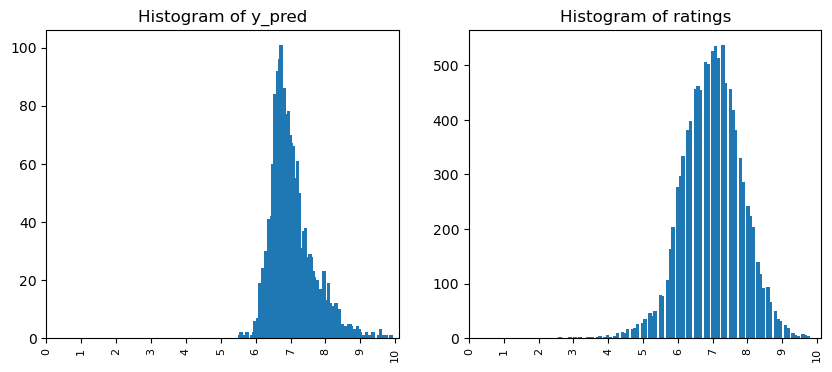

In [9]:
# y_pred에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_pred, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of y_pred')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(y_pred.mean())
print(data['rating'].mean())

In [12]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(y_pred, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence


2.4113026077013195